In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from optimizer.adam import AdamThicknessOptimizer
from utils.loss import calculate_RMS_f_spec

from analyze_utils.make_design import make_reflection_design

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

from analyze_utils.structure import plot_layer_thickness
from analyze_utils.result_io import load
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2

import matplotlib.cm as cmap
import matplotlib.patches as mpatches

## Different OT - Bragg structure

In [2]:
def make_rand_new_film_dif_gt(gt):
    layers = 200
    d = np.random.random(layers) * gt / layers * 2 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', d)
    return film

# Experiment setup (thickness GD)
design = make_reflection_design(make_rand_new_film_dif_gt(0))
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 50
gts = np.linspace(200, 5000, 20)


# Run Experiment!
# loss_rep_ls = []
# film_rep_ls = []
# for rep_i in range(rep):
#     loss_ls = []
#     film_ls = []
#     print(rep_i / rep)
#     for gt in gts:
#         adam_optimizer = AdamThicknessOptimizer(
#             make_rand_new_film_dif_gt(gt), 
#             target, 
#             500, 
#             alpha=1, 
#             show=False, 
#             record=True, 
#             batch_size_wl=50
#         )
#         films, losses = adam_optimizer()
#         loss_ls.append(losses)
#         film_ls.append(films)
#     loss_rep_ls.append(loss_ls)
#     film_rep_ls.append(film_ls)

# working_file = './gts'
# with open(working_file, 'wb') as file:
#     pickle.dump({'film': film_rep_ls, 'loss': loss_rep_ls}, file)

In [3]:
working_file = './raw_result/gts'

with open(working_file, 'rb') as file:
    res = pickle.load(file)
    film_rep_ls = res['film']
    loss_rep_ls = res['loss']


In [4]:
# Process loss_rep (thickness GD)
# loss_rep_arr = np.array([[l[-1] for l in rep] for rep in loss_rep_ls])
loss_rep_arr = np.array([[min(losses) for losses in losses_ls] for losses_ls in loss_rep_ls])


In [38]:
# analyze helpers

def calculate_dif_Bragg(film: film_mod.TwoMaterialFilm, dA, dB):
    # NOTE: film keeps the material of the first layer in remove negative layers.
    # The first layer is SiO2.
    d = film.get_d()
    dif = 0
    for i, di in enumerate(d):
        dif += min(abs(di - [dA, dB][i % 2]), abs(di - 0))
    return dif / d.sum()

def plot_rep(ax, x, arr, label):
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    c = next(c_gen)
    ax.plot(x, arr_mean, label=label, c=c)
    ax.fill_between(x, arr_mean - arr_std, arr_mean + arr_std, alpha=0.4, color=c)
    return ax

def plot_rep_violin(ax, x, arr, label):
    c = next(c_gen)
    print(arr.shape, len(x))
    arr_ls = [arr[:, i] for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=100
    )
    
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )

# make reference: DBR
def loss_DBR(gt):
    d_tot = 0
    i = 0
    while True:
        this_d = [d_TiO2, d_SiO2][i % 2]
        d_tot += this_d
        if d_tot > gt:
            break
        i += 1
    last_d = this_d - (d_tot - gt)
    d = np.array([d_TiO2, d_SiO2] * (i // 2) + [d_TiO2] * (i % 2) + [last_d])
    film = film_mod.TwoMaterialFilm('TiO2', 'SiO2', 'SiO2', d)
    return calculate_RMS_f_spec(film, target)

def color():
    i = 0
    while True:
        yield f'C{i}'
        i += 1

In [6]:
# load free form result
free_films_rep, free_losses_rep, free_best_film_rep = load('./raw_result/back_reflector_result')

In [7]:


# Calculate dif!
wl = 800.
d_SiO2 = wl / 4 / get_n_SiO2(wl)
d_TiO2 = wl / 4 / get_n_TiO2(wl)

dif = []
for films in film_rep_ls:
    dif.append([])
    for film in [f[-1] for f in films]:
        film.remove_negative_thickness_layer()
        # plot_thickness_idx(film)
        # print(calculate_RMS_f_spec(film, target))

        dif[-1].append(calculate_dif_Bragg(film, d_SiO2, d_TiO2))
dif = np.array(dif)

(50, 20) 20


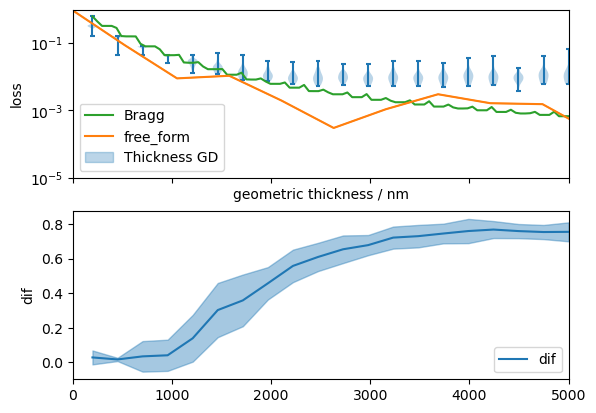

In [40]:
c_gen = color()
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
# thickness gd
violin_handle_1 = plot_rep_violin(ax, gts, loss_rep_arr, 'Thickness GD')
# DBR
gts_dense = np.linspace(gts[0], gts[-1], 100)
ax.plot(gts_dense, [loss_DBR(gt) for gt in gts_dense], label='Bragg', c='C2')
# free form
plot_rep(
    ax, 
    np.array([films[-1].get_d().sum() for films in free_films_rep[0]]), 
    np.array([[min(l) for l in ls] for ls in free_losses_rep]), 
    'free_form'
)

ax.set_ylabel('loss')
auto_handles, _ = ax.get_legend_handles_labels()
auto_handles.append(violin_handle_1)
ax.legend(
    handles=auto_handles, 
    loc='lower left'
)
ax.set_xlabel('geometric thickness / nm')
ax.set_yscale('log')
ax.set_xlim(0, 5000)
ax.set_ylim(1e-5, 1)



c_gen = color()

ax2 = plot_rep(ax2, gts, dif, 'dif')
ax2.set_ylabel('dif')
ax2.legend(loc='lower right')

# ax2.set_yscale('log')


In [ ]:

def plot_thickness_idx(f):
    d = f.get_d()
    fig, ax = plt.subplots(1, 1)
    wl = np.array([750.])
    s = ax.scatter(range(d.shape[0]), d, marker='o', cmap='coolwarm', c=f.calculate_n_array(wl)[0, :])
    cbar = fig.colorbar(s)
    cbar.set_label('n')

    # target: 800 nm DBR
    wl = 800.
    d_SiO2 = wl / 4 / get_n_SiO2(wl)
    d_TiO2 = wl / 4 / get_n_TiO2(wl)
    
    ax.plot([0, d.shape[0]], [d_SiO2, d_SiO2], c=cmap.get_cmap('coolwarm')(0), alpha=0.4, ls='--')
    ax.plot([0, d.shape[0]], [d_TiO2, d_TiO2], c=cmap.get_cmap('coolwarm')(0.99), alpha=0.4, ls='--')
    ax.set_xlabel('index')
    ax.set_ylabel('thickness')
    return fig, ax

f: film_mod.TwoMaterialFilm = film_rep_ls[6][0][-1] # 5, 19, 50, 64, 68, 89
f.add_spec_param(target[0].INC_ANG, target[0].WLS)
f.remove_negative_thickness_layer()

plot_layer_thickness(f)
_, ax = plot_thickness_idx(f)
ax.set_title(f'loss: {calculate_RMS_f_spec(f, target)}')